# 1. 数据基础分析

In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
import gc
import tqdm
import warnings
import matplotlib.font_manager as fm
from collections import defaultdict, Counter

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import multiprocessing
from joblib import Parallel, delayed
import networkx as nx
import psutil

warnings.filterwarnings('ignore')

font_path = 'C:/Windows/Fonts/msyh.ttc'
font_prop = fm.FontProperties(fname=font_path)

plt.style.use('ggplot')
%matplotlib inline

In [15]:
data_dir = Path("F:\postgraduate\课程\研一下\数据挖掘\\torrents\\new\\30G_data_new")
parquet_files = [file for file in data_dir.glob("*.parquet")]

In [10]:
df_sample = pd.read_parquet(parquet_files[0], engine='pyarrow')

print("数据基本信息:")
print(f"行数: {len(df_sample)}")
print(f"列数: {len(df_sample.columns)}")
print("\n列名和数据类型:")
print(df_sample.dtypes)

print("\n数据预览:")
print(df_sample.head())

if 'purchase_history' in df_sample.columns:
    print("\npurchase_history字段示例:")
    for idx, row in df_sample.iterrows():
        if pd.notna(row['purchase_history']):
            purchase_example = json.loads(row['purchase_history'])
            print(json.dumps(purchase_example, indent=4, ensure_ascii=False))
            break

del df_sample
gc.collect()

数据基本信息:
行数: 8437500
列数: 15

列名和数据类型:
id                     int64
last_login            object
user_name             object
fullname              object
email                 object
age                    int64
income               float64
gender                object
country               object
address               object
purchase_history      object
is_active               bool
registration_date     object
phone_number          object
login_history         object
dtype: object

数据预览:
   id                 last_login   user_name fullname               email  \
0   0  2024-03-19T19:35:16+00:00  OFVIUGZMWH      覃泽川  lnsqjypb@gmail.com   
1   1  2025-02-21T05:08:16+00:00      KMLBNE      吕泽越     zddfsdkt@qq.com   
2   2  2024-11-26T09:33:05+00:00     NGTSMVK      卞泽楠    qxgqdrfd@163.com   
3   3  2023-10-19T17:32:56+00:00      IJLZVS       卞鹏    jbjxirrf@163.com   
4   4  2024-05-09T00:01:29+00:00       XCLES       郎雪     cnerwras@qq.com   

   age     income gender country            

33

# 2. 商品类别关联规则挖掘

## 2.1. 数据提取与预处理

In [16]:
# 读取商品目录
product_catalog_path = Path("F:/postgraduate/课程/研一下/数据挖掘/torrents/product_catalog.json/product_catalog.json")
with open(product_catalog_path, 'r', encoding='utf-8') as f:
    product_catalog = json.load(f)

In [17]:
# 创建商品ID到类别的映射字典
item_category_map = {}
for product in product_catalog['products']:
    item_id = product['id']
    category = product['category']
    item_category_map[item_id] = category

print(f"已加载 {len(item_category_map)} 个商品的类别信息")
print(f"商品类别种类数量: {len(set(item_category_map.values()))}")
print("\n前10个商品类别示例:")
for i, (item_id, category) in enumerate(list(item_category_map.items())[:10]):
    print(f"商品ID: {item_id}, 类别: {category}")

已加载 10000 个商品的类别信息
商品类别种类数量: 42

前10个商品类别示例:
商品ID: 1, 类别: 上衣
商品ID: 2, 类别: 儿童课外读物
商品ID: 3, 类别: 帽子
商品ID: 4, 类别: 内衣
商品ID: 5, 类别: 鞋子
商品ID: 6, 类别: 健身器材
商品ID: 7, 类别: 户外装备
商品ID: 8, 类别: 米面
商品ID: 9, 类别: 蛋奶
商品ID: 10, 类别: 蛋奶


## 2.2. 用户购物篮提取

In [7]:
def process_chunk(chunk, item_category_map):
    basket_list = []
    skip_count = 0
    
    for purchase_history in chunk['purchase_history']:
        if pd.notna(purchase_history):
            try:
                purchase = json.loads(purchase_history)
                
                if 'items' in purchase and isinstance(purchase['items'], list):
                    basket = []
                    for item in purchase['items']:
                        if 'id' in item and item['id'] in item_category_map:
                            category = item_category_map[item['id']]
                            basket.append(category)
                    
                    if len(basket) > 1:
                        basket_list.append(basket)
                    else:
                        skip_count += 1
                else:
                    skip_count += 1
            except (json.JSONDecodeError, TypeError):
                skip_count += 1
    
    return basket_list, skip_count

In [8]:
# 设置处理参数
n_cores = multiprocessing.cpu_count() - 4
chunk_size = 10000
baskets = []
processed_files = 0
total_processed = 0
total_skipped = 0
sample_ratio = 0.3

with tqdm.tqdm(total=len(parquet_files), desc="提取购物篮数据") as pbar:
    for file in parquet_files:
        try:
            df = pd.read_parquet(file, columns=['purchase_history'], engine='pyarrow').sample(frac=sample_ratio)
            chunks = [df.iloc[i:i+chunk_size] for i in range(0, len(df), chunk_size)]

            results = Parallel(n_jobs=n_cores)(
                delayed(process_chunk)(chunk, item_category_map) for chunk in chunks
            )
            
            for basket_list, skip_count in results:
                baskets.extend(basket_list)
                total_skipped += skip_count
            
            total_processed += len(df)
            
            del df, chunks, results
            gc.collect()
            
            processed_files += 1
            pbar.update(1)
            
            if processed_files % 4 == 0:
                print(f"\n已处理 {processed_files}/{len(parquet_files)} 个文件")
                
        except Exception as e:
            print(f"\n处理文件 {file} 时出错: {e}")
            continue

print(f"平均每个购物篮的商品类别数量: {sum(len(basket) for basket in baskets) / len(baskets) if baskets else 0:.2f}")

提取购物篮数据:  25%|██▌       | 4/16 [01:21<03:55, 19.62s/it]


已处理 4/16 个文件


提取购物篮数据:  50%|█████     | 8/16 [02:49<03:03, 22.96s/it]


已处理 8/16 个文件


提取购物篮数据:  75%|███████▌  | 12/16 [04:11<01:24, 21.02s/it]


已处理 12/16 个文件


提取购物篮数据: 100%|██████████| 16/16 [05:45<00:00, 21.58s/it]



已处理 16/16 个文件
平均每个购物篮的商品类别数量: 3.50


## 2.3. Apriori算法挖掘频繁项集

In [10]:
# 转换购物篮为适合mlxtend处理的格式
baskets_filtered = [basket for basket in baskets if len(basket) > 1]
te = TransactionEncoder()
te_ary = te.fit_transform(baskets_filtered)
df_baskets = pd.DataFrame(te_ary, columns=te.columns_)

# 应用Apriori算法挖掘频繁项集，支持度设置为0.02
min_support = 0.02
# frequent_itemsets = apriori(df_baskets, min_support=min_support, use_colnames=True)
frequent_itemsets = apriori(df_baskets, min_support=min_support, use_colnames=True, low_memory=True)

print(f"找到 {len(frequent_itemsets)} 个支持度≥{min_support}的频繁项集")

# 统计频繁项集大小分布并展示
itemset_sizes = frequent_itemsets['itemsets'].apply(lambda x: len(x))
size_counts = itemset_sizes.value_counts().sort_index()
print("\n频繁项集大小分布:")
for size, count in size_counts.items():
    print(f"{size}项集的数量: {count}")

print("\n部分频繁项集示例:")
for _, row in frequent_itemsets.sort_values('support', ascending=False).head(10).iterrows():
    items = list(row['itemsets'])
    support = row['support']
    print(f"项集: {items}, 支持度: {support:.4f}")

找到 42 个支持度≥0.02的频繁项集

频繁项集大小分布:
1项集的数量: 42

部分频繁项集示例:
项集: ['模型'], 支持度: 0.0884
项集: ['围巾'], 支持度: 0.0880
项集: ['文具'], 支持度: 0.0877
项集: ['卫浴用品'], 支持度: 0.0861
项集: ['水果'], 支持度: 0.0858
项集: ['饮料'], 支持度: 0.0851
项集: ['智能手机'], 支持度: 0.0847
项集: ['裙子'], 支持度: 0.0840
项集: ['零食'], 支持度: 0.0839
项集: ['耳机'], 支持度: 0.0831


## 2.4. 关联规则及其分析

In [11]:
# 生成关联规则，置信度阈值设置为0.5
min_confidence = 0.5
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)

print(f"\n找到 {len(rules)} 个置信度≥{min_confidence}的关联规则")

rules["lift"] = rules["lift"].astype(float)
rules["leverage"] = rules["leverage"].astype(float) 
rules["conviction"] = rules["conviction"].astype(float)

rules = rules.sort_values("lift", ascending=False)

print("\n部分关联规则示例(按提升度排序):")
pd.set_option('display.max_colwidth', None)
rule_display = rules.head(10)[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

# 格式化antecedents和consequents为易读形式
rule_display['antecedents'] = rule_display['antecedents'].apply(lambda x: list(x))
rule_display['consequents'] = rule_display['consequents'].apply(lambda x: list(x))
print(rule_display)


找到 0 个置信度≥0.5的关联规则

部分关联规则示例(按提升度排序):
Empty DataFrame
Columns: [antecedents, consequents, support, confidence, lift]
Index: []


In [ ]:
# 绘制散点图展示关联规则的支持度、置信度和提升度
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(
    x='support', 
    y='confidence', 
    size='lift',
    hue='lift',
    data=rules,
    sizes=(50, 200),
    palette='viridis'
)

# 增加气泡大小的图例
handles, labels = scatter.get_legend_handles_labels()
plt.legend(handles, labels, title='提升度(Lift)', title_fontproperties=font_prop, 
           prop=font_prop, loc='lower right')

plt.title('关联规则散点图', fontsize=14, fontproperties=font_prop)
plt.xlabel('支持度 (Support)', fontsize=12, fontproperties=font_prop)
plt.ylabel('置信度 (Confidence)', fontsize=12, fontproperties=font_prop)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 绘制前10个最强关联规则的网络图
if len(rules) > 0:
    plt.figure(figsize=(14, 10))
    
    top_rules = rules.head(10)
    
    # 创建节点和边的数据
    G = nx.DiGraph()
    
    # 添加节点和边
    for _, rule in top_rules.iterrows():
        antecedents = list(rule['antecedents'])
        consequents = list(rule['consequents'])
        
        for a in antecedents:
            if a not in G.nodes:
                G.add_node(a)
        
        for c in consequents:
            if c not in G.nodes:
                G.add_node(c)
            
        for a in antecedents:
            for c in consequents:
                G.add_edge(a, c, weight=rule['lift'], confidence=rule['confidence'])
    
    # 定义节点位置
    pos = nx.spring_layout(G, k=0.8)
    
    # 绘制节点
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='skyblue')
    
    # 绘制边，粗细与提升度成比例
    edges = G.edges(data=True)
    weights = [data['weight'] * 0.5 for _, _, data in edges]
    nx.draw_networkx_edges(G, pos, width=weights, edge_color='gray', 
                          arrowsize=20, connectionstyle='arc3,rad=0.1')
    
    # 添加节点标签
    labels = {node: node for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, font_family='SimHei')
    
    plt.title('商品类别关联规则网络图', fontproperties=font_prop, fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# 3. 支付方式与商品类别的关联分析

## 3.1. 数据提取和预处理

In [18]:
# 定义支付方式与商品类别关联分析的数据提取函数
def process_payment_category_chunk(chunk, item_category_map):
    payment_category_list = []
    high_value_payments = []
    skip_count = 0
    
    for purchase_history in chunk['purchase_history']:
        if pd.notna(purchase_history):
            try:
                purchase = json.loads(purchase_history)
                
                if ('items' in purchase and isinstance(purchase['items'], list) and 
                    'payment_method' in purchase):
                    
                    payment_method = purchase['payment_method']
                    categories = []
                    high_value_item = False
                    avg_price = 0
                    
                    for item in purchase['items']:
                        if 'id' in item and item['id'] in item_category_map:
                            category = item_category_map[item['id']]
                            categories.append(category)
                    
                    if 'avg_price' in purchase:
                        try:
                            avg_price = float(purchase['avg_price'])
                            if avg_price > 5000:
                                high_value_item = True
                        except (ValueError, TypeError):
                            pass
                    
                    if categories:
                        for category in categories:
                            payment_category_list.append((payment_method, category))
                        
                        if high_value_item:
                            high_value_payments.append({
                                'payment_method': payment_method,
                                'categories': categories,
                                'price': avg_price
                            })
                    else:
                        skip_count += 1
                else:
                    skip_count += 1
            except (json.JSONDecodeError, TypeError):
                skip_count += 1
    
    return payment_category_list, high_value_payments, skip_count

In [19]:
# 设置处理参数
n_cores = multiprocessing.cpu_count() - 4
chunk_size = 10000
payment_category_data = []
high_value_data = []
processed_files = 0
total_processed = 0
total_skipped = 0
sample_ratio = 0.1


with tqdm.tqdm(total=len(parquet_files), desc="提取支付方式与类别关联数据") as pbar:
    for file in parquet_files:
        try:
            df = pd.read_parquet(file, columns=['purchase_history'], engine='pyarrow').sample(frac=sample_ratio)
            chunks = [df.iloc[i:i+chunk_size] for i in range(0, len(df), chunk_size)]

            results = Parallel(n_jobs=n_cores)(
                delayed(process_payment_category_chunk)(chunk, item_category_map) for chunk in chunks
            )
            
            for payment_category_list, high_value_payments, skip_count in results:
                payment_category_data.extend(payment_category_list)
                high_value_data.extend(high_value_payments)
                total_skipped += skip_count
            
            total_processed += len(df)
            
            del df, chunks, results
            gc.collect()
            
            processed_files += 1
            pbar.update(1)
            
            if processed_files % 4 == 0:
                memory_usage = psutil.Process().memory_info().rss / (1024 * 1024)
                print(f"\n已处理 {processed_files}/{len(parquet_files)} 个文件")
                
        except Exception as e:
            print(f"\n处理文件 {file} 时出错: {e}")
            continue

print(f"总共提取 {len(high_value_data)} 条高价值商品记录")

提取支付方式与类别关联数据:  25%|██▌       | 4/16 [28:30<1:29:52, 449.36s/it]


已处理 4/16 个文件


提取支付方式与类别关联数据:  50%|█████     | 8/16 [1:02:52<1:07:13, 504.23s/it]


已处理 8/16 个文件


提取支付方式与类别关联数据:  75%|███████▌  | 12/16 [1:41:16<37:11, 557.97s/it] 


已处理 12/16 个文件


提取支付方式与类别关联数据: 100%|██████████| 16/16 [2:21:07<00:00, 529.22s/it]


已处理 16/16 个文件
总共提取 6755939 条高价值商品记录


## 3.2. 关联规则挖掘数据

In [20]:
# 支付方式与类别的基本统计
payment_method_counter = Counter([item[0] for item in payment_category_data])
category_counter = Counter([item[1] for item in payment_category_data])

total_payments = len(payment_category_data)

print("\n支付方式分布:")
for payment, count in payment_method_counter.most_common():
    print(f"  {payment}: {count} ({count/total_payments*100:.2f}%)")

# 高价值商品的支付方式分析
high_value_payments = Counter([item['payment_method'] for item in high_value_data])
high_value_total = len(high_value_data)

print("\n高价值商品(>5000)的支付方式分布:")
for payment, count in high_value_payments.most_common():
    print(f"  {payment}: {count} ({count/high_value_total*100:.2f}%)")

# 高价值商品中最常见的商品类别
high_value_categories = Counter()
for item in high_value_data:
    for category in item['categories']:
        high_value_categories[category] += 1

print("\n高价值商品中最常见的商品类别(Top 10):")
for category, count in high_value_categories.most_common(10):
    print(f"  {category}: {count} ({count/high_value_total*100:.2f}%)")


支付方式分布:
  储蓄卡: 5794019 (14.31%)
  云闪付: 5792406 (14.30%)
  支付宝: 5789122 (14.29%)
  现金: 5788444 (14.29%)
  银联: 5780936 (14.27%)
  微信支付: 5777585 (14.27%)
  信用卡: 5777219 (14.26%)

高价值商品(>5000)的支付方式分布:
  储蓄卡: 966795 (14.31%)
  支付宝: 966152 (14.30%)
  云闪付: 965656 (14.29%)
  微信支付: 964483 (14.28%)
  银联: 964467 (14.28%)
  信用卡: 964341 (14.27%)
  现金: 964045 (14.27%)

高价值商品中最常见的商品类别(Top 10):
  模型: 531139 (7.86%)
  围巾: 529341 (7.84%)
  文具: 526472 (7.79%)
  卫浴用品: 516740 (7.65%)
  水果: 515708 (7.63%)
  饮料: 510648 (7.56%)
  智能手机: 509897 (7.55%)
  裙子: 504305 (7.46%)
  零食: 502385 (7.44%)
  耳机: 498397 (7.38%)


In [9]:
# 转换为适合关联规则挖掘的格式，每条记录是一个元组(支付方式, 商品类别)
transactions = []
for payment, category in payment_category_data:
    transactions.append([f"支付方式_{payment}", f"类别_{category}"])

te = TransactionEncoder()
te_ary = te.fit_transform(transactions)
df_transactions = pd.DataFrame(te_ary, columns=te.columns_)

min_support = 0.01
frequent_itemsets = apriori(df_transactions, min_support=min_support, use_colnames=True, low_memory=True)

print(f"找到 {len(frequent_itemsets)} 个支持度≥{min_support}的频繁项集")

min_confidence = 0.6
payment_rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)

print(f"\n找到 {len(payment_rules)} 个置信度≥{min_confidence}的关联规则")

payment_rules["lift"] = payment_rules["lift"].astype(float)
payment_rules = payment_rules.sort_values("lift", ascending=False)

找到 49 个支持度≥0.01的频繁项集

找到 0 个置信度≥0.6的关联规则


In [10]:
# 提取支付方式到类别的规则
payment_to_category_rules = payment_rules[
    payment_rules['antecedents'].apply(lambda x: all('支付方式_' in str(item) for item in x)) &
    payment_rules['consequents'].apply(lambda x: all('类别_' in str(item) for item in x))
]

print(f"\n支付方式→商品类别的规则数量: {len(payment_to_category_rules)}")

# 显示支付方式→商品类别的规则
if not payment_to_category_rules.empty:
    print("\n支付方式→商品类别的规则 (Top 10):")
    rule_display = payment_to_category_rules.head(10)[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
    
    rule_display['antecedents'] = rule_display['antecedents'].apply(
        lambda x: [item.replace('支付方式_', '') for item in x]
    )
    rule_display['consequents'] = rule_display['consequents'].apply(
        lambda x: [item.replace('类别_', '') for item in x]
    )
    print(rule_display)


支付方式→商品类别的规则数量: 0


In [11]:
# 提取类别到支付方式的规则
category_to_payment_rules = payment_rules[
    payment_rules['antecedents'].apply(lambda x: all('类别_' in str(item) for item in x)) &
    payment_rules['consequents'].apply(lambda x: all('支付方式_' in str(item) for item in x))
]

print(f"\n商品类别→支付方式的规则数量: {len(category_to_payment_rules)}")

# 显示商品类别→支付方式的规则
if not category_to_payment_rules.empty:
    print("\n商品类别→支付方式的规则 (Top 10):")
    rule_display = category_to_payment_rules.head(10)[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
    
    rule_display['antecedents'] = rule_display['antecedents'].apply(
        lambda x: [item.replace('类别_', '') for item in x]
    )
    rule_display['consequents'] = rule_display['consequents'].apply(
        lambda x: [item.replace('支付方式_', '') for item in x]
    )
    print(rule_display)


商品类别→支付方式的规则数量: 0


## 3.3. 高价值商品支付方式分析

In [12]:
# 高价值商品的支付方式详细分析
if high_value_data:
    payment_avg_price = defaultdict(list)
    for item in high_value_data:
        payment_avg_price[item['payment_method']].append(item['price'])
    
    payment_price_stats = {}
    for payment, prices in payment_avg_price.items():
        payment_price_stats[payment] = {
            'count': len(prices),
            'avg_price': np.mean(prices),
            'median_price': np.median(prices),
            'max_price': max(prices),
            'min_price': min(prices)
        }
    
    payment_price_df = pd.DataFrame([
        {
            'payment_method': payment,
            'count': stats['count'],
            'avg_price': stats['avg_price'],
            'median_price': stats['median_price'],
            'max_price': stats['max_price'],
            'min_price': stats['min_price']
        }
        for payment, stats in payment_price_stats.items()
    ])
    
    payment_price_df = payment_price_df.sort_values('avg_price', ascending=False)
    
    print("\n高价值商品的支付方式统计 (按平均价格排序):")
    print(payment_price_df)
    
    # 高价值商品的类别-支付方式组合分析
    high_value_category_payment = Counter()
    for item in high_value_data:
        for category in item['categories']:
            high_value_category_payment[(category, item['payment_method'])] += 1
    
    print("\n高价值商品的类别-支付方式组合 (Top 20):")
    for (category, payment), count in high_value_category_payment.most_common(20):
        print(f"  {category} + {payment}: {count} ({count/high_value_total*100:.2f}%)")


高价值商品的支付方式统计 (按平均价格排序):
  payment_method   count    avg_price  median_price  max_price  min_price
6            云闪付  966750  7501.217380        7501.5    10000.0     5001.0
2             银联  965040  7501.072796        7502.0    10000.0     5001.0
1           微信支付  965785  7499.850076        7498.0    10000.0     5001.0
3             现金  963901  7498.846836        7498.0    10000.0     5001.0
5            信用卡  965242  7498.717763        7498.0    10000.0     5001.0
0            储蓄卡  964950  7498.665331        7500.0    10000.0     5001.0
4            支付宝  965707  7498.393421        7494.0    10000.0     5001.0

高价值商品的类别-支付方式组合 (Top 20):
  模型 + 支付宝: 76537 (1.13%)
  模型 + 微信支付: 76213 (1.13%)
  模型 + 银联: 76051 (1.13%)
  围巾 + 微信支付: 76029 (1.13%)
  模型 + 云闪付: 75893 (1.12%)
  围巾 + 支付宝: 75834 (1.12%)
  模型 + 信用卡: 75789 (1.12%)
  模型 + 储蓄卡: 75781 (1.12%)
  围巾 + 信用卡: 75724 (1.12%)
  模型 + 现金: 75716 (1.12%)
  围巾 + 银联: 75676 (1.12%)
  围巾 + 云闪付: 75665 (1.12%)
  文具 + 微信支付: 75604 (1.12%)
  围巾 + 现金: 75602 (

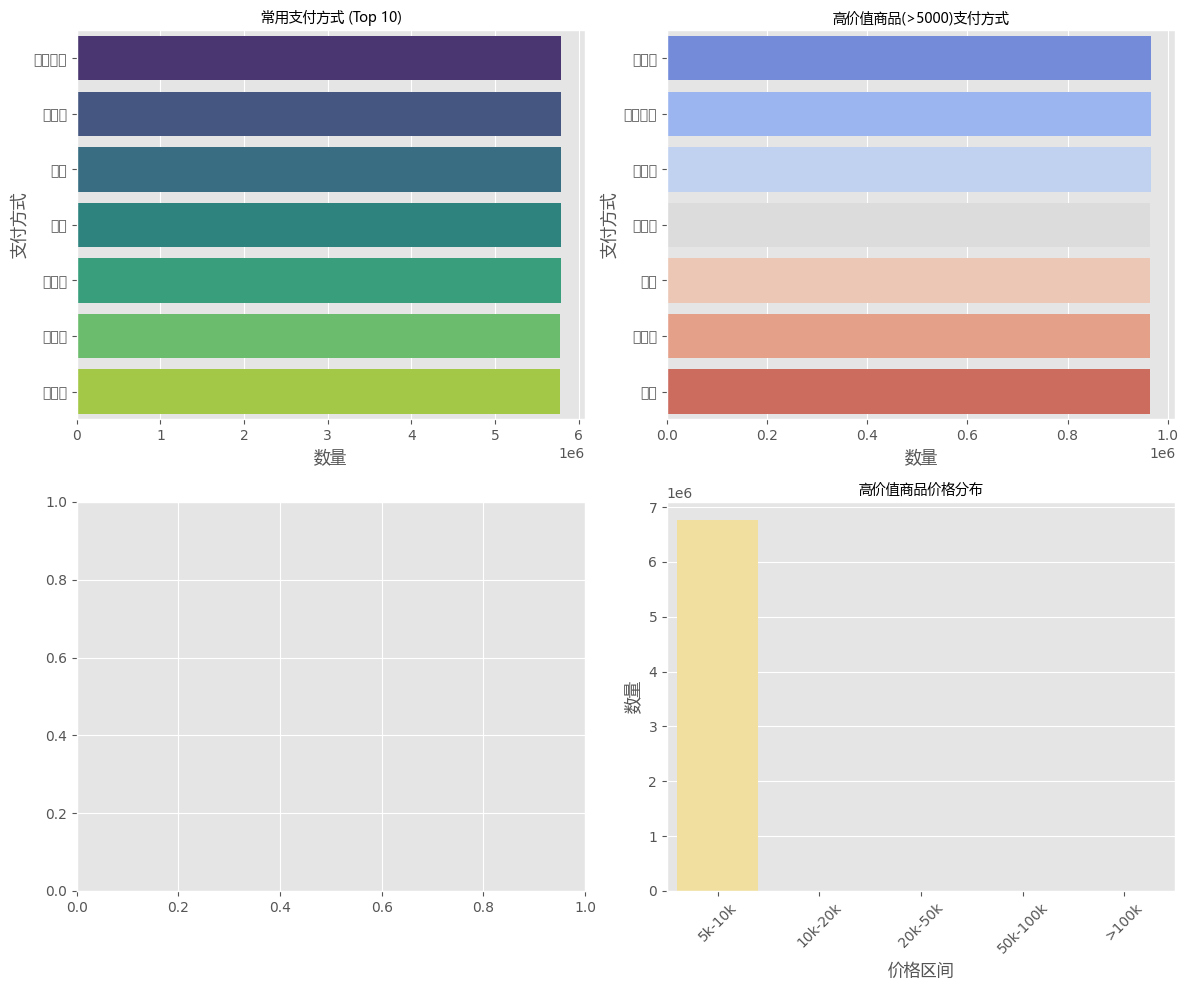

In [21]:
# 支付方式与商品类别关联规则可视化
plt.figure(figsize=(12, 10))

payments_df = pd.DataFrame({
    'Payment': list(payment_method_counter.keys()),
    'Count': list(payment_method_counter.values())
}).sort_values('Count', ascending=False).head(10)

plt.subplot(2, 2, 1)
sns.barplot(x='Count', y='Payment', data=payments_df, palette='viridis')
plt.title('常用支付方式 (Top 10)', fontsize=14, fontproperties=font_prop)
plt.xlabel('数量', fontsize=12, fontproperties=font_prop)
plt.ylabel('支付方式', fontsize=12, fontproperties=font_prop)

high_value_df = pd.DataFrame({
    'Payment': list(high_value_payments.keys()),
    'Count': list(high_value_payments.values())
}).sort_values('Count', ascending=False)

plt.subplot(2, 2, 2)
sns.barplot(x='Count', y='Payment', data=high_value_df, palette='coolwarm')
plt.title('高价值商品(>5000)支付方式', fontsize=14, fontproperties=font_prop)
plt.xlabel('数量', fontsize=12, fontproperties=font_prop)
plt.ylabel('支付方式', fontsize=12, fontproperties=font_prop)

# 关联规则散点图
plt.subplot(2, 2, 3)
if not category_to_payment_rules.empty:
    sns.scatterplot(
        x='support', 
        y='confidence',
        size='lift',
        hue='lift',
        data=category_to_payment_rules,
        palette='viridis',
        sizes=(50, 200)
    )
    plt.title('商品类别→支付方式关联规则', fontsize=14, fontproperties=font_prop)
    plt.xlabel('支持度', fontsize=12, fontproperties=font_prop)
    plt.ylabel('置信度', fontsize=12, fontproperties=font_prop)

    # 修复中文图例问题
    handles, labels = scatter.get_legend_handles_labels()
    plt.legend(handles, labels, title='提升度(Lift)', title_fontproperties=font_prop, 
               prop=font_prop, loc='lower right')
    
    # 确保坐标轴标签使用中文字体
    plt.xticks(fontproperties=font_prop)
    plt.yticks(fontproperties=font_prop)

# 高价值商品价格区间分布
plt.subplot(2, 2, 4)
if high_value_data:
    high_price_bins = [5000, 10000, 20000, 50000, 100000, float('inf')]
    high_price_labels = ['5k-10k', '10k-20k', '20k-50k', '50k-100k', '>100k']
    
    prices = [item['price'] for item in high_value_data]
    price_cats = pd.cut(prices, bins=high_price_bins, labels=high_price_labels)
    price_dist = price_cats.value_counts().sort_index()
    
    sns.barplot(x=price_dist.index, y=price_dist.values, palette='YlOrRd')
    plt.title('高价值商品价格分布', fontsize=14, fontproperties=font_prop)
    plt.xlabel('价格区间', fontsize=12, fontproperties=font_prop)
    plt.ylabel('数量', fontsize=12, fontproperties=font_prop)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 4. 时间序列模式挖掘

## 4.1. 数据提取与预处理

In [21]:
# 定义时间序列数据提取函数
def process_time_series_chunk(chunk, item_category_map):
    """处理一个数据块，提取购买时间和商品类别的关联数据"""
    time_category_data = []
    user_sequence_data = defaultdict(list)
    skip_count = 0
    
    for idx, purchase_history in enumerate(chunk['purchase_history']):
        if pd.notna(purchase_history):
            try:
                purchase = json.loads(purchase_history)
                
                if ('items' in purchase and isinstance(purchase['items'], list) and 
                    'purchase_date' in purchase):
                    
                    try:
                        purchase_date = pd.to_datetime(purchase['purchase_date'])
                        
                        year = purchase_date.year
                        month = purchase_date.month
                        quarter = (month - 1) // 3 + 1
                        week = purchase_date.isocalendar()[1]
                        weekday = purchase_date.weekday()
                        
                        categories = []
                        for item in purchase['items']:
                            if 'id' in item and item['id'] in item_category_map:
                                category = item_category_map[item['id']]
                                categories.append(category)
                                
                                time_category_data.append({
                                    'date': purchase_date,
                                    'year': year,
                                    'quarter': quarter,
                                    'month': month,
                                    'week': week,
                                    'weekday': weekday,
                                    'category': category
                                })
                        
                        if categories:
                            user_id = f"user_{idx}"
                            user_sequence_data[user_id].append({
                                'date': purchase_date,
                                'categories': categories
                            })
                    except ValueError:
                        skip_count += 1
                else:
                    skip_count += 1
            except (json.JSONDecodeError, TypeError):
                skip_count += 1
    
    for user_id, sequence in user_sequence_data.items():
        sequence.sort(key=lambda x: x['date'])
    
    return time_category_data, user_sequence_data, skip_count

In [6]:
# 设置处理参数
n_cores = multiprocessing.cpu_count() - 4
chunk_size = 10000
time_category_data = []
user_sequence_data = {}
processed_files = 0
total_processed = 0
total_skipped = 0
sample_ratio = 0.01


with tqdm.tqdm(total=len(parquet_files), desc="提取时间序列数据") as pbar:
    for file in parquet_files:
        try:
            df = pd.read_parquet(file, columns=['purchase_history'], engine='pyarrow').sample(frac=sample_ratio)
            chunks = [df.iloc[i:i+chunk_size] for i in range(0, len(df), chunk_size)]

            results = Parallel(n_jobs=n_cores)(
                delayed(process_time_series_chunk)(chunk, item_category_map) for chunk in chunks
            )
            
            for time_cat_data, user_seq_data, skip_count in results:
                time_category_data.extend(time_cat_data)
                user_sequence_data.update(user_seq_data)
                total_skipped += skip_count
            
            total_processed += len(df)
            
            del df, chunks, results
            gc.collect()
            
            processed_files += 1
            pbar.update(1)
            
            if processed_files % 4 == 0:
                memory_usage = psutil.Process().memory_info().rss / (1024 * 1024)
                print(f"\n已处理 {processed_files}/{len(parquet_files)} 个文件")
                
        except Exception as e:
            print(f"\n处理文件 {file} 时出错: {e}")
            continue


time_df = pd.DataFrame(time_category_data)

提取时间序列数据:  25%|██▌       | 4/16 [01:23<04:04, 20.41s/it]


已处理 4/16 个文件


提取时间序列数据:  50%|█████     | 8/16 [02:44<02:41, 20.21s/it]


已处理 8/16 个文件


提取时间序列数据:  75%|███████▌  | 12/16 [04:10<01:25, 21.43s/it]


已处理 12/16 个文件


提取时间序列数据: 100%|██████████| 16/16 [05:31<00:00, 20.71s/it]



已处理 16/16 个文件


## 4.2. 季节性购物模式分析


购买数据的时间跨度:
起始日期: 2020-01-01 00:00:00
结束日期: 2025-03-24 00:00:00

月度购买分布:
month
1     394069
2     360996
3     379631
4     317362
5     330779
6     315890
7     331041
8     328224
9     318051
10    328904
11    317673
12    329365
dtype: int64

季度购买分布:
quarter
1    1134696
2     964031
3     977316
4     975942
dtype: int64

星期几购买分布:
周一: 578264
周二: 578142
周三: 580084
周四: 578460
周五: 579675
周六: 579539
周日: 577821


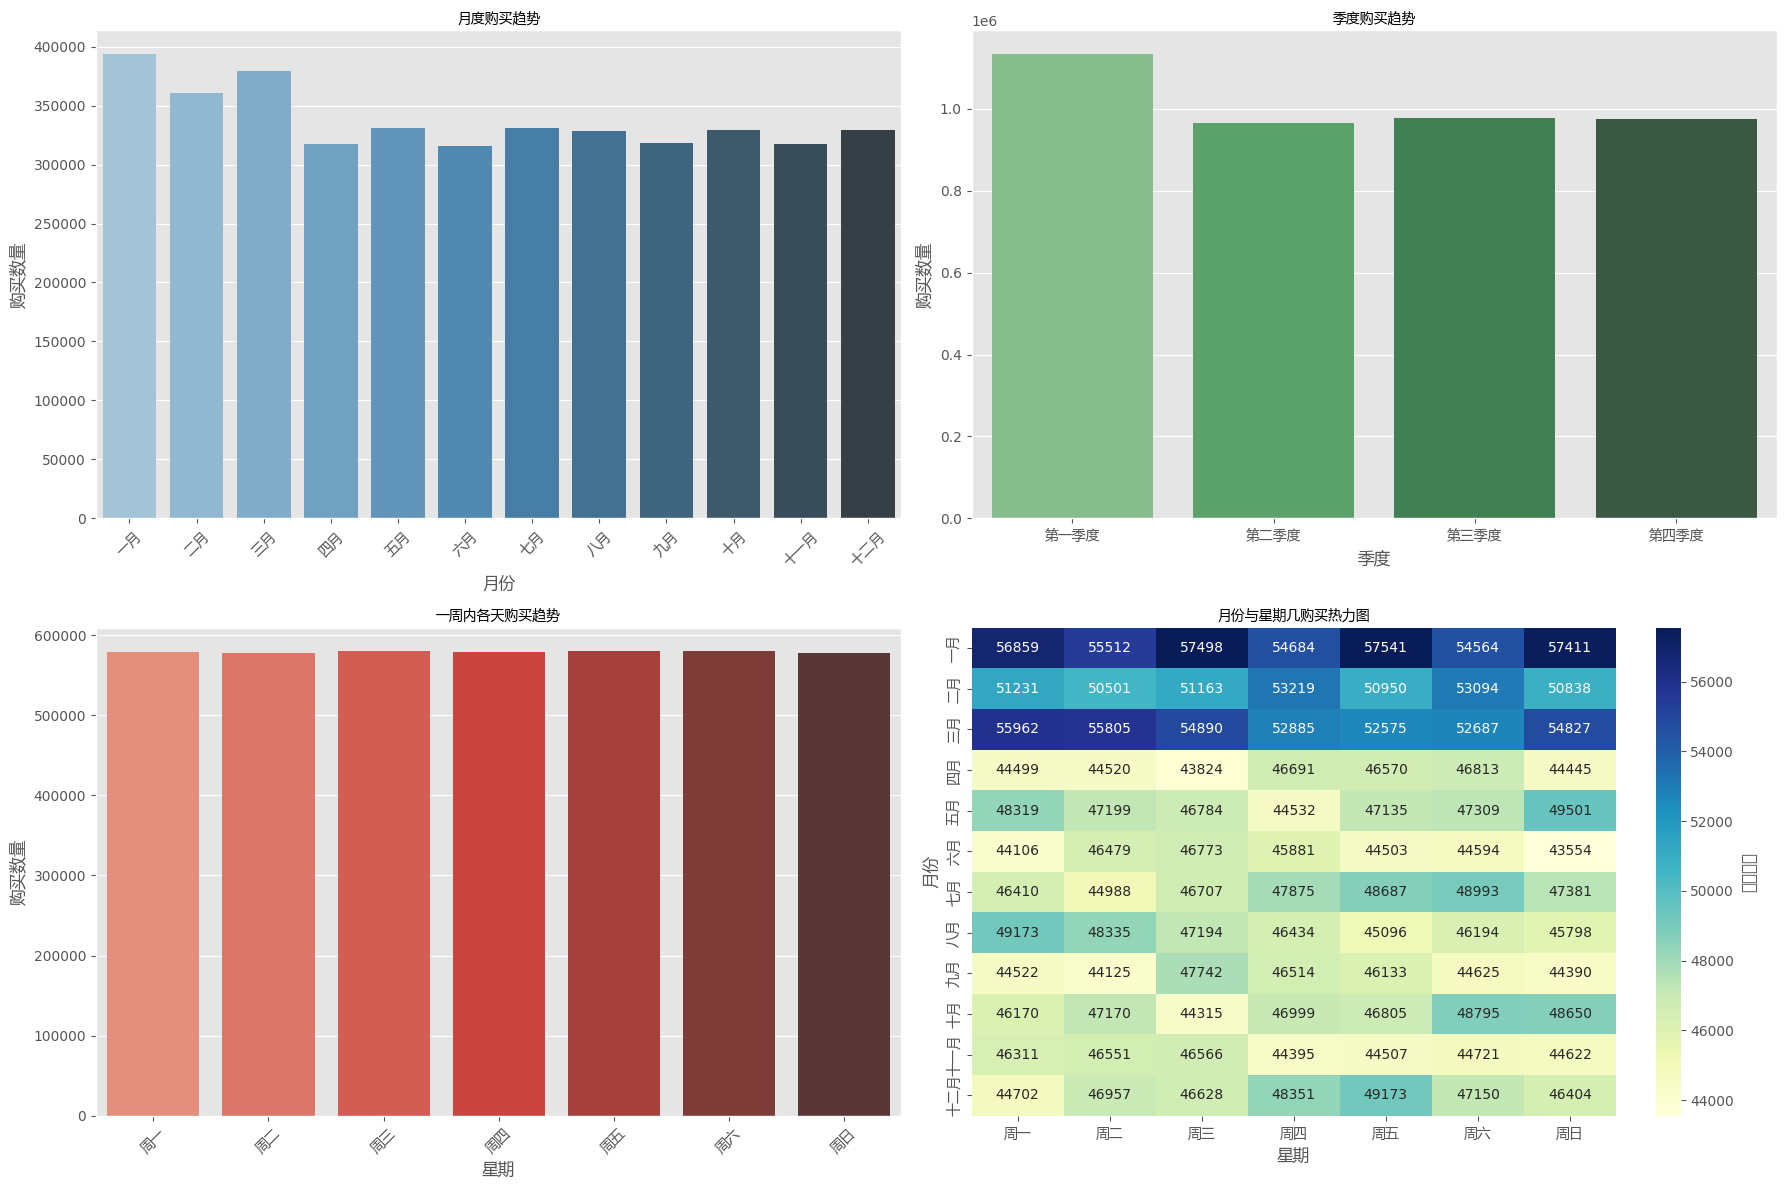

In [7]:
# 分析购物行为的季节性模式
print("\n购买数据的时间跨度:")
print(f"起始日期: {time_df['date'].min()}")
print(f"结束日期: {time_df['date'].max()}")

monthly_purchase = time_df.groupby('month').size()
print("\n月度购买分布:")
print(monthly_purchase)

quarterly_purchase = time_df.groupby('quarter').size()
print("\n季度购买分布:")
print(quarterly_purchase)

weekday_purchase = time_df.groupby('weekday').size()
print("\n星期几购买分布:")
weekday_names = ['周一', '周二', '周三', '周四', '周五', '周六', '周日']
for day, count in enumerate(weekday_purchase):
    print(f"{weekday_names[day]}: {count}")

# 可视化季节性模式
plt.figure(figsize=(18, 12))

plt.subplot(2, 2, 1)
month_labels = ['一月', '二月', '三月', '四月', '五月', '六月', 
                '七月', '八月', '九月', '十月', '十一月', '十二月']
monthly_df = pd.DataFrame({
    'month': range(1, 13),
    'count': [monthly_purchase.get(i, 0) for i in range(1, 13)]
}).sort_values('month')

sns.barplot(x='month', y='count', data=monthly_df, palette='Blues_d')
plt.title('月度购买趋势', fontsize=14, fontproperties=font_prop)
plt.xlabel('月份', fontsize=12, fontproperties=font_prop)
plt.ylabel('购买数量', fontsize=12, fontproperties=font_prop)
plt.xticks(range(12), month_labels, rotation=45, fontproperties=font_prop)

plt.subplot(2, 2, 2)
quarter_labels = ['第一季度', '第二季度', '第三季度', '第四季度']
quarterly_df = pd.DataFrame({
    'quarter': range(1, 5),
    'count': [quarterly_purchase.get(i, 0) for i in range(1, 5)]
}).sort_values('quarter')

sns.barplot(x='quarter', y='count', data=quarterly_df, palette='Greens_d')
plt.title('季度购买趋势', fontsize=14, fontproperties=font_prop)
plt.xlabel('季度', fontsize=12, fontproperties=font_prop)
plt.ylabel('购买数量', fontsize=12, fontproperties=font_prop)
plt.xticks(range(4), quarter_labels, fontproperties=font_prop)

plt.subplot(2, 2, 3)
weekday_df = pd.DataFrame({
    'weekday': range(7),
    'count': [weekday_purchase.get(i, 0) for i in range(7)]
})

sns.barplot(x='weekday', y='count', data=weekday_df, palette='Reds_d')
plt.title('一周内各天购买趋势', fontsize=14, fontproperties=font_prop)
plt.xlabel('星期', fontsize=12, fontproperties=font_prop)
plt.ylabel('购买数量', fontsize=12, fontproperties=font_prop)
plt.xticks(range(7), weekday_names, rotation=45, fontproperties=font_prop)

# 热力图：月份vs星期几
plt.subplot(2, 2, 4)
month_weekday = time_df.groupby(['month', 'weekday']).size().unstack(fill_value=0)
sns.heatmap(month_weekday, cmap='YlGnBu', annot=True, fmt='d', cbar_kws={'label': '购买数量'})
plt.title('月份与星期几购买热力图', fontsize=14, fontproperties=font_prop)
plt.xlabel('星期', fontsize=12, fontproperties=font_prop)
plt.ylabel('月份', fontsize=12, fontproperties=font_prop)
plt.yticks(np.arange(0.5, 12.5), month_labels, fontproperties=font_prop)
plt.xticks(np.arange(0.5, 7.5), weekday_names, fontproperties=font_prop)

plt.tight_layout()
plt.show()

## 4.3. 特定商品类别时间变化分析

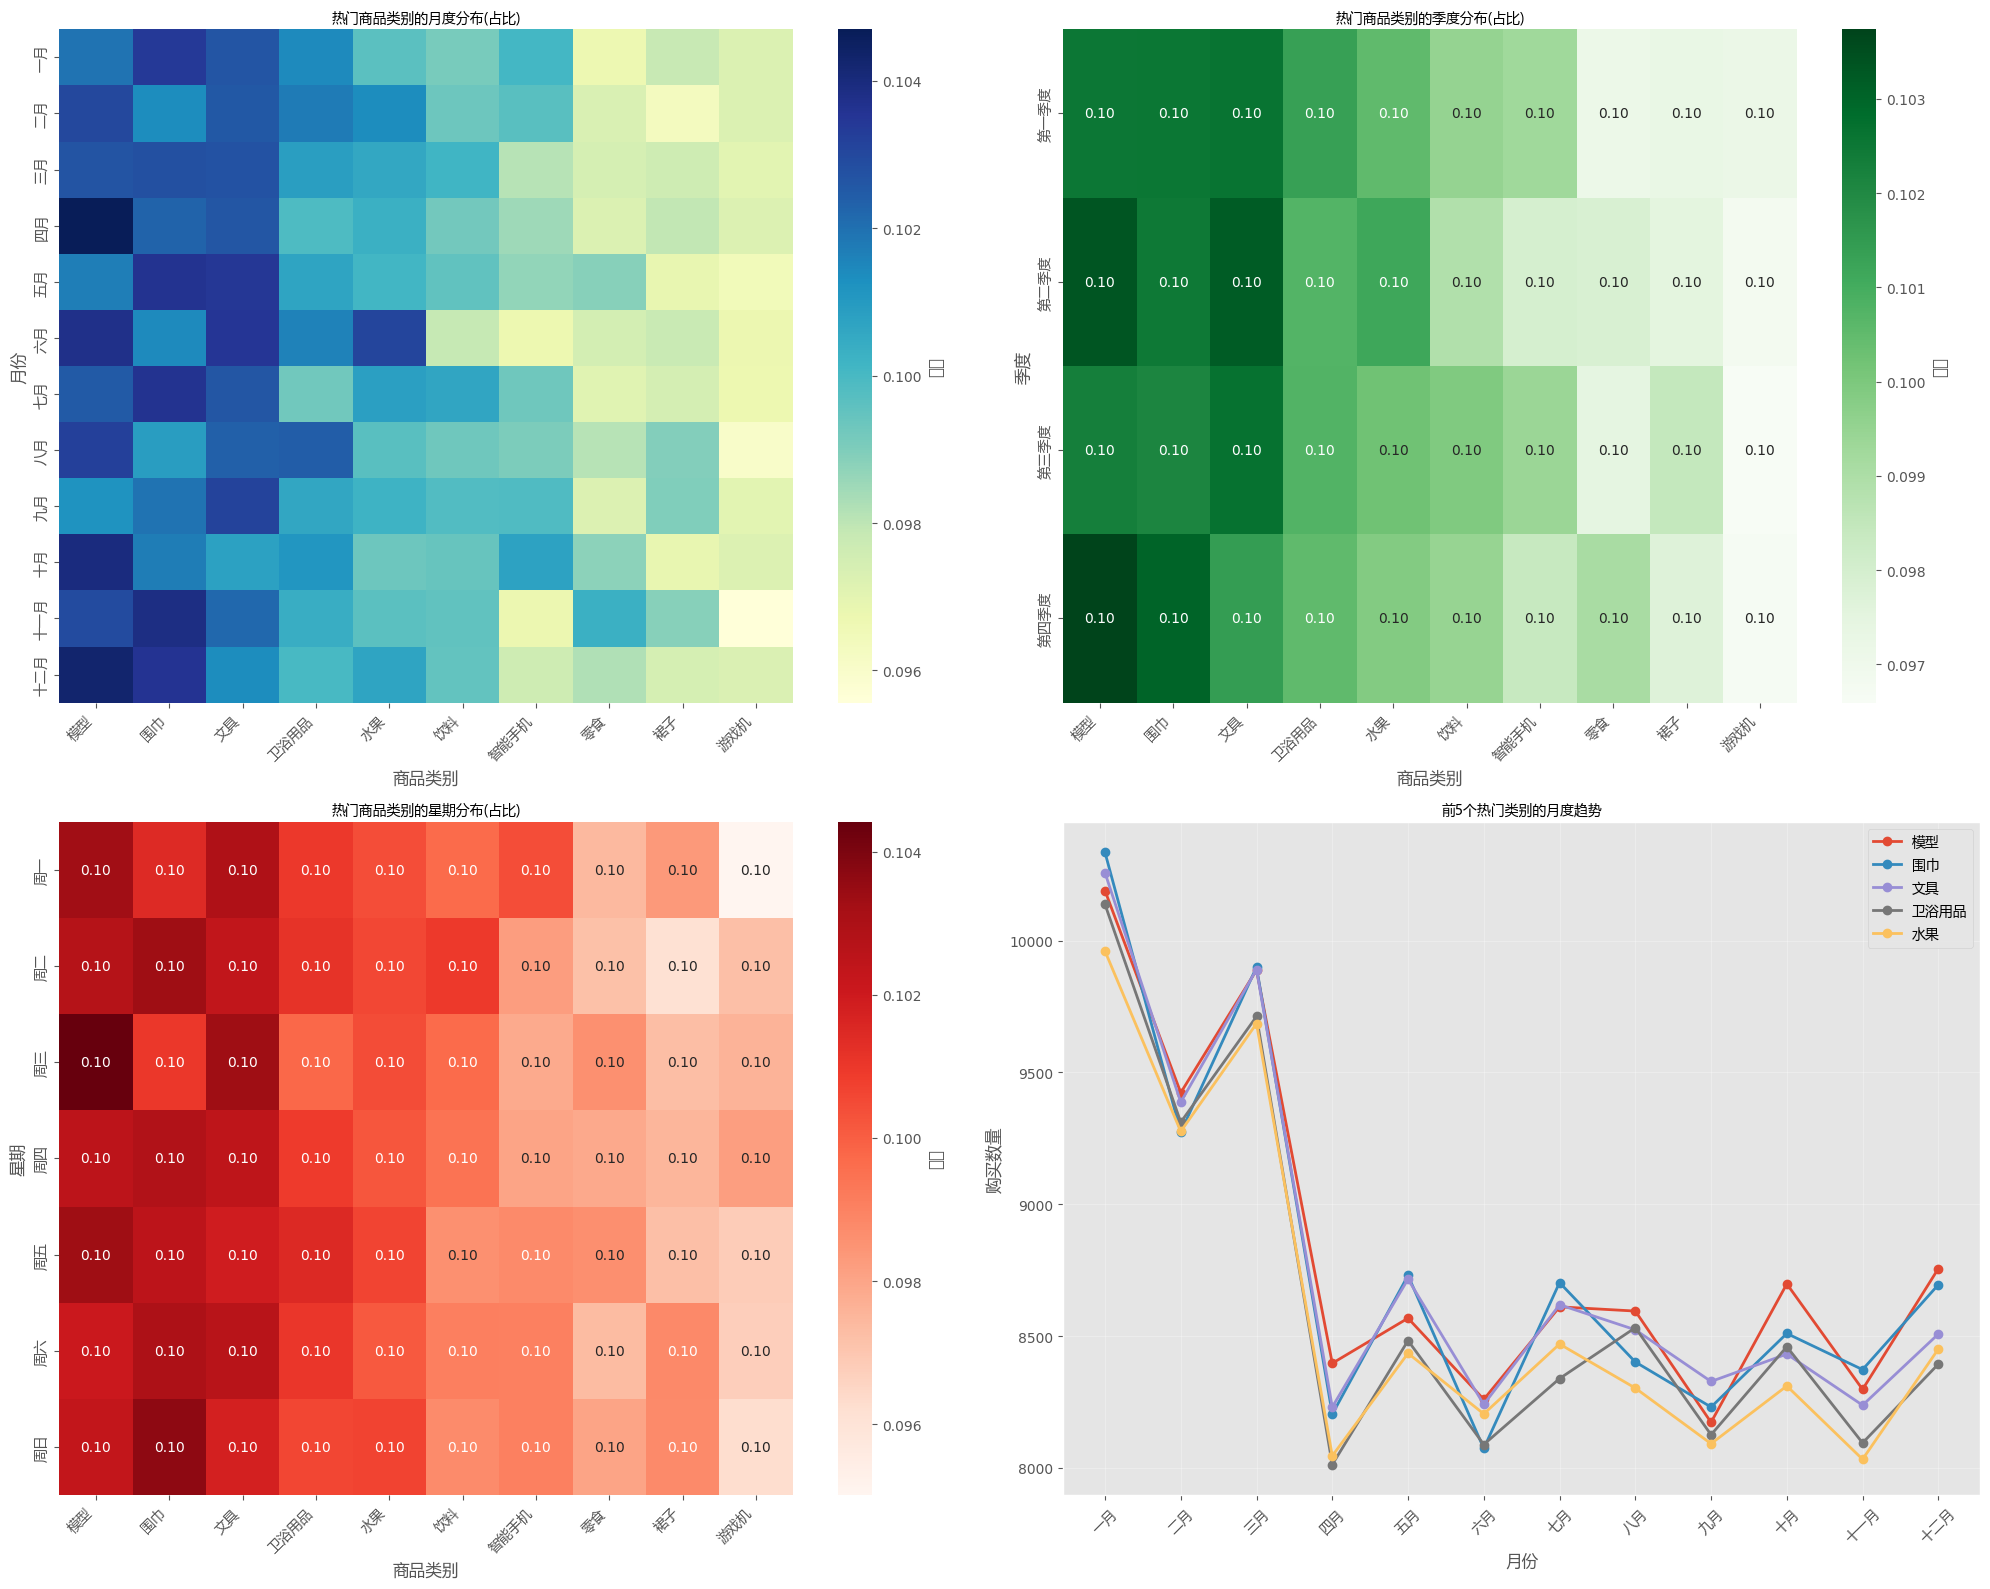

In [8]:
# 识别特定商品类别在不同时间段的购买频率变化
# 获取前10个热门类别
top_categories = time_df['category'].value_counts().head(10).index.tolist()

plt.figure(figsize=(20, 16))

plt.subplot(2, 2, 1)
month_category = pd.crosstab(time_df['month'], time_df['category'])
month_category = month_category[top_categories]

month_category_pct = month_category.div(month_category.sum(axis=1), axis=0)

# 热图展示月度类别分布
sns.heatmap(month_category_pct, cmap='YlGnBu', annot=False, cbar_kws={'label': '占比'})
plt.title('热门商品类别的月度分布(占比)', fontsize=14, fontproperties=font_prop)
plt.xlabel('商品类别', fontsize=12, fontproperties=font_prop)
plt.ylabel('月份', fontsize=12, fontproperties=font_prop)
plt.yticks(np.arange(0.5, 12.5), month_labels, fontproperties=font_prop)
plt.xticks(rotation=45, ha='right', fontproperties=font_prop)

plt.subplot(2, 2, 2)
quarter_category = pd.crosstab(time_df['quarter'], time_df['category'])
quarter_category = quarter_category[top_categories]

quarter_category_pct = quarter_category.div(quarter_category.sum(axis=1), axis=0)

# 热图展示季度类别分布
sns.heatmap(quarter_category_pct, cmap='Greens', annot=True, fmt='.2f', cbar_kws={'label': '占比'})
plt.title('热门商品类别的季度分布(占比)', fontsize=14, fontproperties=font_prop)
plt.xlabel('商品类别', fontsize=12, fontproperties=font_prop)
plt.ylabel('季度', fontsize=12, fontproperties=font_prop)
plt.yticks(np.arange(0.5, 4.5), quarter_labels, fontproperties=font_prop)
plt.xticks(rotation=45, ha='right', fontproperties=font_prop)

plt.subplot(2, 2, 3)
weekday_category = pd.crosstab(time_df['weekday'], time_df['category'])
weekday_category = weekday_category[top_categories]

weekday_category_pct = weekday_category.div(weekday_category.sum(axis=1), axis=0)

# 热图展示星期几类别分布
sns.heatmap(weekday_category_pct, cmap='Reds', annot=True, fmt='.2f', cbar_kws={'label': '占比'})
plt.title('热门商品类别的星期分布(占比)', fontsize=14, fontproperties=font_prop)
plt.xlabel('商品类别', fontsize=12, fontproperties=font_prop)
plt.ylabel('星期', fontsize=12, fontproperties=font_prop)
plt.yticks(np.arange(0.5, 7.5), weekday_names, fontproperties=font_prop)
plt.xticks(rotation=45, ha='right', fontproperties=font_prop)

# 按月份绘制类别趋势线
plt.subplot(2, 2, 4)
for category in top_categories[:5]:
    category_monthly = time_df[time_df['category'] == category].groupby('month').size()
    plt.plot(range(1, 13), [category_monthly.get(i, 0) for i in range(1, 13)], 
             marker='o', linewidth=2, label=category)

plt.title('前5个热门类别的月度趋势', fontsize=14, fontproperties=font_prop)
plt.xlabel('月份', fontsize=12, fontproperties=font_prop)
plt.ylabel('购买数量', fontsize=12, fontproperties=font_prop)
plt.xticks(range(1, 13), month_labels, rotation=45, fontproperties=font_prop)
plt.legend(prop=font_prop)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4.4. 时序模式挖掘

In [9]:
# 探索"先购买A类别，后购买B类别"的时序模式
def extract_category_sequences(user_data, min_time_diff=1, max_time_diff=180):
    """提取用户的商品类别购买序列
    min_time_diff: 最小时间间隔(天)，避免同一天多次购买
    max_time_diff: 最大时间间隔(天)，限制相关性的时间窗口
    """
    category_sequences = []
    
    for user_id, purchases in user_data.items():
        if len(purchases) < 2:
            continue
            
        sorted_purchases = sorted(purchases, key=lambda x: x['date'])
        
        for i in range(len(sorted_purchases) - 1):
            for j in range(i + 1, len(sorted_purchases)):
                time_diff = (sorted_purchases[j]['date'] - sorted_purchases[i]['date']).days
                
                if min_time_diff <= time_diff <= max_time_diff:
                    for cat_i in sorted_purchases[i]['categories']:
                        for cat_j in sorted_purchases[j]['categories']:
                            if cat_i != cat_j:
                                category_sequences.append((cat_i, cat_j, time_diff))
    
    return category_sequences

print("正在提取类别序列模式...")
category_sequences = extract_category_sequences(user_sequence_data)
print(f"共提取到 {len(category_sequences)} 个类别序列关系")

sequence_counter = Counter([(a, b) for a, b, _ in category_sequences])
total_sequences = len(category_sequences)

sequence_support = {}
for (a, b), count in sequence_counter.items():
    sequence_support[(a, b)] = count / total_sequences

top_sequences = sequence_counter.most_common(20)
print("\n最常见的类别序列模式 (Top 20):")
for (a, b), count in top_sequences:
    support = sequence_support[(a, b)]
    print(f"{a} → {b}: {count} 次, 支持度: {support:.4f}")

sequence_timelag = defaultdict(list)
for a, b, time_diff in category_sequences:
    sequence_timelag[(a, b)].append(time_diff)

print("\n常见序列模式的平均时间间隔 (天):")
for (a, b), count in top_sequences:
    avg_time = np.mean(sequence_timelag[(a, b)])
    median_time = np.median(sequence_timelag[(a, b)])
    print(f"{a} → {b}: 平均 {avg_time:.1f} 天, 中位数 {median_time:.1f} 天")

正在提取类别序列模式...
共提取到 0 个类别序列关系

最常见的类别序列模式 (Top 20):

常见序列模式的平均时间间隔 (天):


In [ ]:
# 可视化时序模式
plt.figure(figsize=(18, 15))

plt.subplot(2, 2, 1)
top10_seq = sequence_counter.most_common(10)
seq_df = pd.DataFrame({
    'Sequence': [f"{a} → {b}" for (a, b), _ in top10_seq],
    'Count': [count for _, count in top10_seq],
    'Support': [sequence_support[(a, b)] for (a, b), _ in top10_seq]
}).sort_values('Count', ascending=False)

sns.barplot(x='Count', y='Sequence', data=seq_df, palette='viridis')
plt.title('最常见的类别序列模式 (Top 10)', fontsize=14, fontproperties=font_prop)
plt.xlabel('次数', fontsize=12, fontproperties=font_prop)
plt.ylabel('序列模式', fontsize=12, fontproperties=font_prop)
plt.grid(True, alpha=0.3, axis='x')

plt.subplot(2, 2, 2)
top5_seq = [pair for pair, _ in top_sequences[:5]]
time_lag_data = []

for (a, b) in top5_seq:
    for time_diff in sequence_timelag[(a, b)]:
        time_lag_data.append({
            'Sequence': f"{a} → {b}",
            'Time_Diff': time_diff
        })

time_lag_df = pd.DataFrame(time_lag_data)
sns.boxplot(x='Sequence', y='Time_Diff', data=time_lag_df, palette='pastel')
plt.title('序列模式的时间间隔分布 (Top 5)', fontsize=14, fontproperties=font_prop)
plt.xlabel('序列模式', fontsize=12, fontproperties=font_prop)
plt.ylabel('时间间隔(天)', fontsize=12, fontproperties=font_prop)
plt.xticks(rotation=45, ha='right', fontproperties=font_prop)
plt.grid(True, alpha=0.3, axis='y')

plt.subplot(2, 1, 2)
G = nx.DiGraph()

for (a, b), count in top_sequences:
    if a not in G.nodes:
        G.add_node(a)
    if b not in G.nodes:
        G.add_node(b)
        
    weight = sequence_support[(a, b)]
    G.add_edge(a, b, weight=weight, count=count)

pos = nx.spring_layout(G, k=0.3, iterations=50, seed=42)

edge_weights = [G[u][v]['weight'] * 10 for u, v in G.edges()]
node_sizes = [300 + 100 * G.degree(node) for node in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue', alpha=0.8)

edges = nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color=edge_weights, 
                              edge_cmap=plt.cm.Blues, arrows=True, arrowstyle='-|>', 
                              arrowsize=15, connectionstyle='arc3,rad=0.1',
                              min_source_margin=15, min_target_margin=15)

labels = {node: node for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=9, 
                       font_family='SimHei', font_weight='bold')

edge_labels = {(u, v): f"{G[u][v]['weight']:.3f}" for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

plt.title('商品类别时序关系网络图', fontsize=16, fontproperties=font_prop)
plt.axis('off')

plt.tight_layout()
plt.show()

# 5. 退款模式分析

## 5.1. 数据提取与预处理

In [22]:
# 定义退款模式数据提取函数
def process_refund_chunk(chunk, item_category_map):
    refund_baskets = []
    refund_status = []
    refund_details = []
    skip_count = 0
    
    for purchase_history in chunk['purchase_history']:
        if pd.notna(purchase_history):
            try:
                purchase = json.loads(purchase_history)
                
                if ('payment_status' in purchase and 
                    ('退款' in purchase['payment_status'] or 
                     'refund' in purchase['payment_status'].lower())):
                    
                    payment_status = purchase['payment_status']
                    categories = []
                    
                    if 'items' in purchase and isinstance(purchase['items'], list):
                        for item in purchase['items']:
                            if 'id' in item and item['id'] in item_category_map:
                                category = item_category_map[item['id']]
                                categories.append(category)
                    
                    if categories:
                        refund_baskets.append(categories)
                        refund_status.append(payment_status)
                        
                        detail = {
                            'categories': categories,
                            'payment_status': payment_status,
                            'payment_method': purchase.get('payment_method', 'Unknown'),
                            'avg_price': float(purchase.get('avg_price', 0)),
                            'purchase_date': purchase.get('purchase_date', None)
                        }
                        refund_details.append(detail)
                    else:
                        skip_count += 1
                else:
                    skip_count += 1
            except (json.JSONDecodeError, TypeError):
                skip_count += 1
    
    return refund_baskets, refund_status, refund_details, skip_count

In [23]:
# 设置处理参数
n_cores = multiprocessing.cpu_count() - 4
chunk_size = 10000
refund_baskets = []
refund_statuses = []
refund_details = []
processed_files = 0
total_processed = 0
total_skipped = 0
sample_ratio = 0.3

with tqdm.tqdm(total=len(parquet_files), desc="提取退款模式数据") as pbar:
    for file in parquet_files:
        try:
            df = pd.read_parquet(file, columns=['purchase_history'], engine='pyarrow').sample(frac=sample_ratio)
            chunks = [df.iloc[i:i+chunk_size] for i in range(0, len(df), chunk_size)]

            results = Parallel(n_jobs=n_cores)(
                delayed(process_refund_chunk)(chunk, item_category_map) for chunk in chunks
            )
            
            for baskets, statuses, details, skip_count in results:
                refund_baskets.extend(baskets)
                refund_statuses.extend(statuses)
                refund_details.extend(details)
                total_skipped += skip_count
            
            total_processed += len(df)
            
            del df, chunks, results
            gc.collect()
            
            processed_files += 1
            pbar.update(1)
            
            if processed_files % 4 == 0:
                memory_usage = psutil.Process().memory_info().rss / (1024 * 1024)
                print(f"\n已处理 {processed_files}/{len(parquet_files)} 个文件")
                
        except Exception as e:
            print(f"\n处理文件 {file} 时出错: {e}")
            continue

print(f"退款状态类型: {set(refund_statuses)}")

提取退款模式数据:  25%|██▌       | 4/16 [14:42<46:57, 234.82s/it]


已处理 4/16 个文件


提取退款模式数据:  50%|█████     | 8/16 [42:28<52:33, 394.15s/it]


已处理 8/16 个文件


提取退款模式数据:  75%|███████▌  | 12/16 [1:23:19<38:48, 582.10s/it]


已处理 12/16 个文件


提取退款模式数据: 100%|██████████| 16/16 [2:15:14<00:00, 507.13s/it]



已处理 16/16 个文件
退款状态类型: {'已退款', '部分退款'}


## 5.2. 退款关联规则挖掘

In [24]:
# 退款数据基本统计分析
refund_status_counter = Counter(refund_statuses)
total_refunds = len(refund_baskets)

print("\n退款状态分布:")
for status, count in refund_status_counter.items():
    print(f"  {status}: {count} ({count/total_refunds*100:.2f}%)")

refund_categories = Counter()
for basket in refund_baskets:
    for category in basket:
        refund_categories[category] += 1

print("\n退款订单中最常见的商品类别 (Top 15):")
for category, count in refund_categories.most_common(15):
    print(f"  {category}: {count} ({count/total_refunds*100:.2f}%)")

basket_sizes = [len(basket) for basket in refund_baskets]
avg_basket_size = np.mean(basket_sizes)
max_basket_size = max(basket_sizes)

print(f"\n退款订单平均商品类别数: {avg_basket_size:.2f}")
print(f"退款订单最大商品类别数: {max_basket_size}")

refund_prices = [detail['avg_price'] for detail in refund_details if detail['avg_price'] > 0]
if refund_prices:
    avg_price = np.mean(refund_prices)
    median_price = np.median(refund_prices)
    print(f"\n退款订单平均价格: {avg_price:.2f}")
    print(f"退款订单价格中位数: {median_price:.2f}")

refund_payment_methods = Counter([detail['payment_method'] for detail in refund_details])
print("\n退款订单支付方式分布 (Top 5):")
for method, count in refund_payment_methods.most_common(5):
    print(f"  {method}: {count} ({count/total_refunds*100:.2f}%)")


退款状态分布:
  已退款: 13504447 (50.01%)
  部分退款: 13498583 (49.99%)

退款订单中最常见的商品类别 (Top 15):
  模型: 2122718 (7.86%)
  围巾: 2115620 (7.83%)
  文具: 2105846 (7.80%)
  卫浴用品: 2064794 (7.65%)
  水果: 2056261 (7.61%)
  饮料: 2040952 (7.56%)
  智能手机: 2033861 (7.53%)
  裙子: 2013837 (7.46%)
  零食: 2010036 (7.44%)
  耳机: 1991373 (7.37%)
  裤子: 1984867 (7.35%)
  游戏机: 1984810 (7.35%)
  益智玩具: 1977478 (7.32%)
  笔记本电脑: 1968389 (7.29%)
  健身器材: 1967104 (7.28%)

退款订单平均商品类别数: 3.00
退款订单最大商品类别数: 5

退款订单平均价格: 5005.02
退款订单价格中位数: 5005.00

退款订单支付方式分布 (Top 5):
  云闪付: 3859353 (14.29%)
  储蓄卡: 3858760 (14.29%)
  信用卡: 3858702 (14.29%)
  现金: 3858616 (14.29%)
  银联: 3857823 (14.29%)


In [25]:
# 应用Apriori算法挖掘退款订单中的频繁项集
min_support = 0.005
te = TransactionEncoder()
te_ary = te.fit_transform(refund_baskets)
df_refund = pd.DataFrame(te_ary, columns=te.columns_)

frequent_refund_itemsets = apriori(df_refund, min_support=min_support, use_colnames=True, low_memory=True)
print(f"\n找到 {len(frequent_refund_itemsets)} 个支持度≥{min_support}的退款频繁项集")

refund_itemset_sizes = frequent_refund_itemsets['itemsets'].apply(lambda x: len(x))
refund_size_counts = refund_itemset_sizes.value_counts().sort_index()
print("\n退款频繁项集大小分布:")
for size, count in refund_size_counts.items():
    print(f"{size}项集的数量: {count}")

min_confidence = 0.4
refund_rules = association_rules(frequent_refund_itemsets, metric="confidence", min_threshold=min_confidence)
print(f"\n找到 {len(refund_rules)} 个置信度≥{min_confidence}的退款关联规则")

refund_rules["lift"] = refund_rules["lift"].astype(float)
refund_rules = refund_rules.sort_values("lift", ascending=False)

print("\n部分退款关联规则示例(按提升度排序):")
if not refund_rules.empty:
    rule_display = refund_rules.head(10)[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
    rule_display['antecedents'] = rule_display['antecedents'].apply(lambda x: list(x))
    rule_display['consequents'] = rule_display['consequents'].apply(lambda x: list(x))
    print(rule_display)


找到 49 个支持度≥0.005的退款频繁项集

退款频繁项集大小分布:
1项集的数量: 42
2项集的数量: 7

找到 0 个置信度≥0.4的退款关联规则

部分退款关联规则示例(按提升度排序):


In [26]:
# 计算各类别的退款率
# 按类别计算退款率
refund_rates = {}
for category, refund_count in refund_categories.items():
    if category in category_counter:
        total_count = category_counter[category]
        refund_rates[category] = refund_count / total_count
    else:
        refund_rates[category] = float('nan')  # 如果没有总数据，则设为NaN

# 展示退款率最高的类别
refund_rate_items = [(k, v) for k, v in refund_rates.items() if not np.isnan(v)]
refund_rate_items.sort(key=lambda x: x[1], reverse=True)

print("\n退款率最高的商品类别 (Top 15):")
for category, rate in refund_rate_items[:15]:
    total = category_counter.get(category, 0)
    refund = refund_categories.get(category, 0)
    print(f"  {category}: {rate*100:.2f}% (退款:{refund}/{total})")

# 分析不同退款状态("已退款"vs"部分退款")的商品类别差异
full_refund_categories = Counter()
partial_refund_categories = Counter()

for i, basket in enumerate(refund_baskets):
    status = refund_statuses[i]
    for category in basket:
        if "部分" in status:
            partial_refund_categories[category] += 1
        else:
            full_refund_categories[category] += 1

print("\n'已退款'状态中最常见的商品类别 (Top 10):")
for category, count in full_refund_categories.most_common(10):
    print(f"  {category}: {count}")

print("\n'部分退款'状态中最常见的商品类别 (Top 10):")
for category, count in partial_refund_categories.most_common(10):
    print(f"  {category}: {count}")


退款率最高的商品类别 (Top 15):
  零食: 200.34% (退款:2010036/1003304)
  健身器材: 200.33% (退款:1967104/981909)
  鞋子: 200.32% (退款:1758313/877748)
  上衣: 200.31% (退款:1839955/918565)
  汽车装饰: 200.29% (退款:1847216/922283)
  裤子: 200.26% (退款:1984867/991152)
  调味品: 200.25% (退款:1799221/898497)
  肉类: 200.25% (退款:1920698/959170)
  内衣: 200.19% (退款:1955145/976641)
  帽子: 200.17% (退款:1920963/959647)
  笔记本电脑: 200.17% (退款:1968389/983370)
  外套: 200.16% (退款:1944855/971636)
  相机: 200.16% (退款:1919731/959087)
  游戏机: 200.15% (退款:1984810/991667)
  儿童课外读物: 200.15% (退款:1953216/975885)

'已退款'状态中最常见的商品类别 (Top 10):
  模型: 1062578
  围巾: 1057255
  文具: 1053038
  卫浴用品: 1032396
  水果: 1028061
  饮料: 1020853
  智能手机: 1015956
  裙子: 1006689
  零食: 1005415
  耳机: 996189

'部分退款'状态中最常见的商品类别 (Top 10):
  模型: 1060140
  围巾: 1058365
  文具: 1052808
  卫浴用品: 1032398
  水果: 1028200
  饮料: 1020099
  智能手机: 1017905
  裙子: 1007148
  零食: 1004621
  耳机: 995184


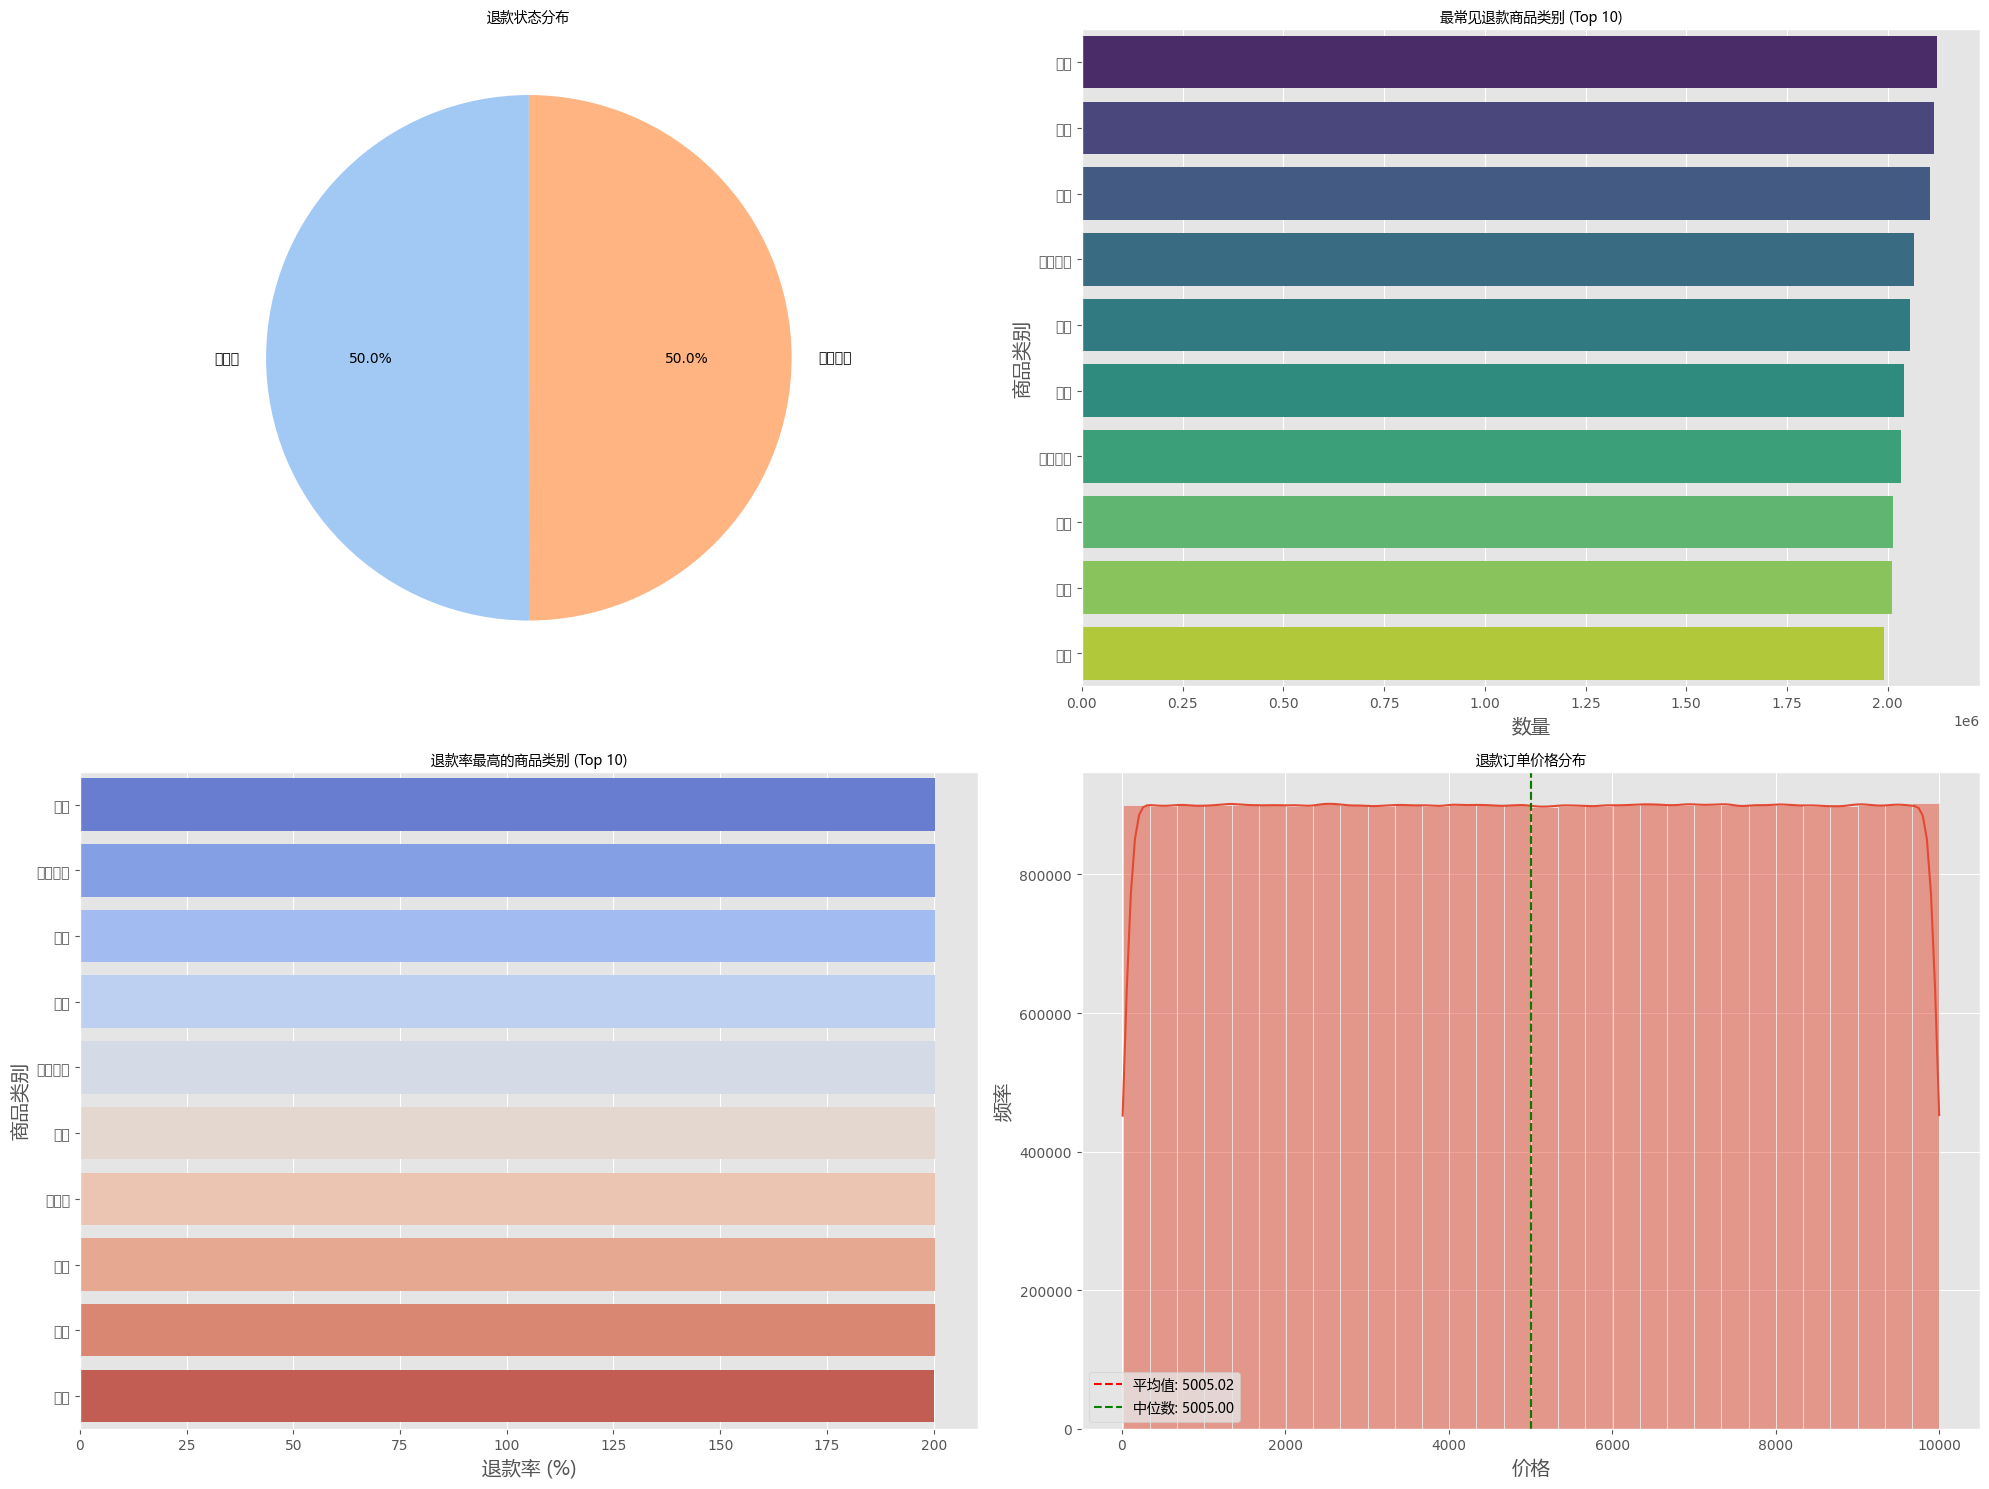

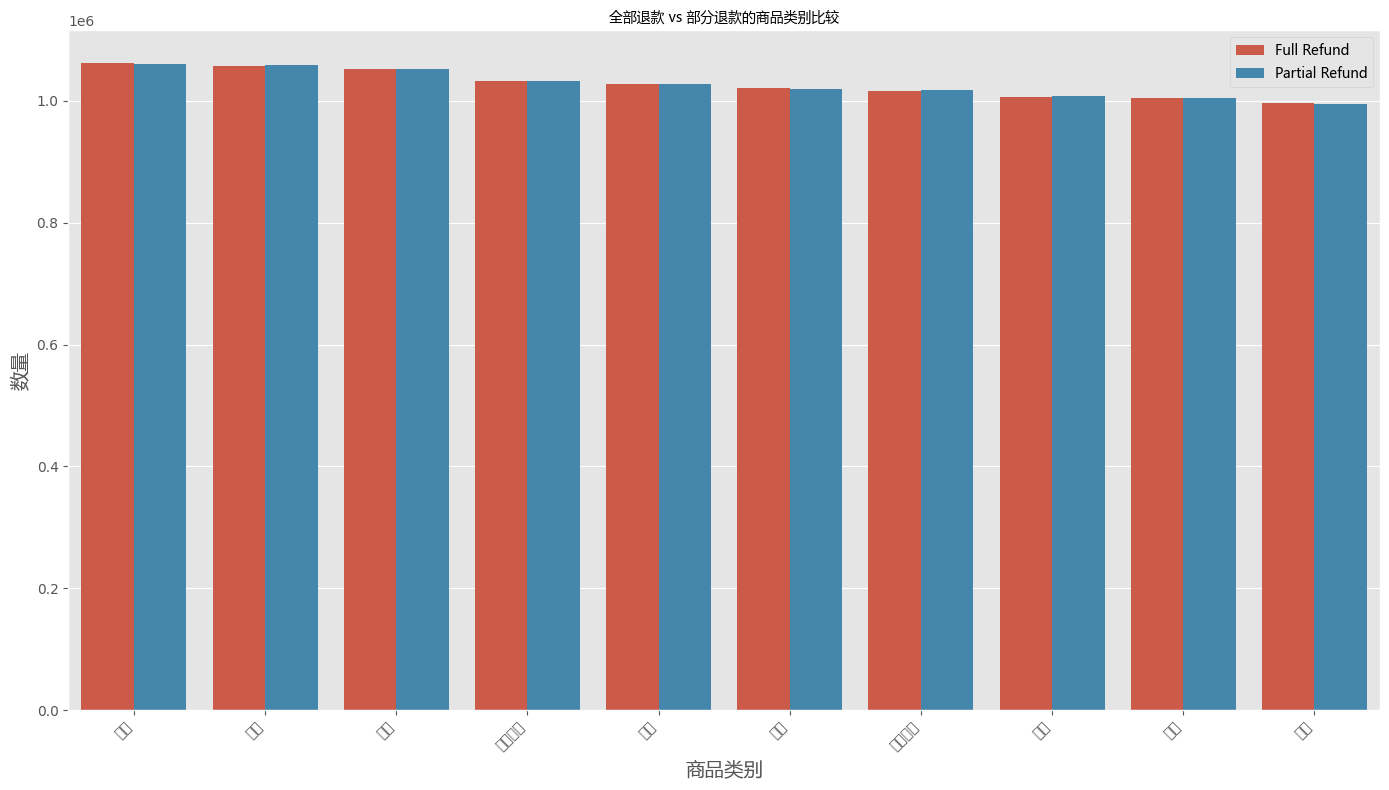

In [27]:
# 可视化退款模式
plt.figure(figsize=(20, 15))

# 1. 退款状态分布饼图
plt.subplot(2, 2, 1)
status_df = pd.DataFrame({
    'Status': list(refund_status_counter.keys()),
    'Count': list(refund_status_counter.values())
})
plt.pie(status_df['Count'], labels=status_df['Status'], autopct='%1.1f%%',
       startangle=90, colors=sns.color_palette('pastel'))
plt.title('退款状态分布', fontsize=16, fontproperties=font_prop)

# 2. 最常见退款商品类别柱状图
plt.subplot(2, 2, 2)
top_refund_categories = dict(refund_categories.most_common(10))
category_df = pd.DataFrame({
    'Category': list(top_refund_categories.keys()),
    'Count': list(top_refund_categories.values())
})
sns.barplot(x='Count', y='Category', data=category_df, palette='viridis')
plt.title('最常见退款商品类别 (Top 10)', fontsize=16, fontproperties=font_prop)
plt.xlabel('数量', fontsize=14, fontproperties=font_prop)
plt.ylabel('商品类别', fontsize=14, fontproperties=font_prop)

# 3. 退款率最高的商品类别
plt.subplot(2, 2, 3)
top_refund_rates = refund_rate_items[:10]
rate_df = pd.DataFrame({
    'Category': [item[0] for item in top_refund_rates],
    'Refund Rate': [item[1]*100 for item in top_refund_rates]
})
sns.barplot(x='Refund Rate', y='Category', data=rate_df, palette='coolwarm')
plt.title('退款率最高的商品类别 (Top 10)', fontsize=16, fontproperties=font_prop)
plt.xlabel('退款率 (%)', fontsize=14, fontproperties=font_prop)
plt.ylabel('商品类别', fontsize=14, fontproperties=font_prop)

# 4. 退款订单价格分布
plt.subplot(2, 2, 4)
if refund_prices:
    sns.histplot(refund_prices, bins=30, kde=True)
    plt.title('退款订单价格分布', fontsize=16, fontproperties=font_prop)
    plt.xlabel('价格', fontsize=14, fontproperties=font_prop)
    plt.ylabel('频率', fontsize=14, fontproperties=font_prop)
    plt.axvline(avg_price, color='r', linestyle='--', label=f'平均值: {avg_price:.2f}')
    plt.axvline(median_price, color='g', linestyle='--', label=f'中位数: {median_price:.2f}')
    plt.legend(prop=font_prop)

plt.tight_layout()
plt.show()

# 绘制退款关联规则网络图
if len(refund_rules) > 0:
    plt.figure(figsize=(12, 10))
    G = nx.DiGraph()
    
    top_rules = refund_rules.head(15)
    for _, rule in top_rules.iterrows():
        antecedents = list(rule['antecedents'])
        consequents = list(rule['consequents'])
        
        for a in antecedents:
            if a not in G.nodes:
                G.add_node(a)
        
        for c in consequents:
            if c not in G.nodes:
                G.add_node(c)
        
        for a in antecedents:
            for c in consequents:
                G.add_edge(a, c, weight=rule['lift'])
    
    pos = nx.spring_layout(G, k=0.5, seed=42)
    
    edges = G.edges()
    weights = [G[u][v]['weight'] for u, v in edges]
    
    nx.draw_networkx_nodes(G, pos, node_size=800, node_color='lightblue', alpha=0.8)
    
    nx.draw_networkx_edges(G, pos, width=[w/2 for w in weights], 
                          edge_color='gray', arrows=True, 
                          connectionstyle='arc3,rad=0.1')
    
    nx.draw_networkx_labels(G, pos, font_size=10, font_family='SimHei')
    
    plt.title('退款商品类别关联规则网络图', fontsize=16, fontproperties=font_prop)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# 全部退款vs部分退款的类别比较
plt.figure(figsize=(14, 8))
top_cats = set([cat for cat, _ in full_refund_categories.most_common(10)] + 
              [cat for cat, _ in partial_refund_categories.most_common(10)])

cat_data = []
for cat in top_cats:
    full = full_refund_categories.get(cat, 0)
    partial = partial_refund_categories.get(cat, 0)
    cat_data.append({
        'Category': cat,
        'Full Refund': full,
        'Partial Refund': partial,
        'Total': full + partial
    })

cat_df = pd.DataFrame(cat_data).sort_values('Total', ascending=False)
cat_df_melt = cat_df.melt(id_vars=['Category'], 
                         value_vars=['Full Refund', 'Partial Refund'],
                         var_name='Refund Type', value_name='Count')

sns.barplot(x='Category', y='Count', hue='Refund Type', data=cat_df_melt)
plt.title('全部退款 vs 部分退款的商品类别比较', fontsize=16, fontproperties=font_prop)
plt.xlabel('商品类别', fontsize=14, fontproperties=font_prop)
plt.ylabel('数量', fontsize=14, fontproperties=font_prop)
plt.xticks(rotation=45, ha='right')
plt.legend(prop=font_prop)
plt.tight_layout()
plt.show()

## 5.3. 高退款商品类别的组合分析

In [ ]:
# 分析高退款率商品的组合模式
high_refund_rate_categories = [item[0] for item in refund_rate_items[:20]]  # 取前20个高退款率类别

# 找出包含这些高退款率类别的购物篮
high_risk_baskets = []
for basket in refund_baskets:
    if any(category in high_refund_rate_categories for category in basket):
        high_risk_baskets.append(basket)

print(f"\n找到 {len(high_risk_baskets)} 个包含高退款率商品类别的购物篮")

# 挖掘这些高风险购物篮中的频繁项集
if len(high_risk_baskets) >= 10:  # 确保有足够的数据
    te_high_risk = TransactionEncoder()
    te_high_risk_ary = te_high_risk.fit_transform(high_risk_baskets)
    df_high_risk = pd.DataFrame(te_high_risk_ary, columns=te_high_risk.columns_)
    
    # 使用较低的支持度阈值
    high_risk_frequent_itemsets = apriori(df_high_risk, min_support=0.005, use_colnames=True)
    print(f"找到 {len(high_risk_frequent_itemsets)} 个高风险购物篮的频繁项集")
    
    # 生成关联规则
    high_risk_rules = association_rules(high_risk_frequent_itemsets, 
                                      metric="confidence", 
                                      min_threshold=0.4)
    
    if not high_risk_rules.empty:
        print("\n高风险商品组合的关联规则 (Top 10):")
        high_risk_rules = high_risk_rules.sort_values("lift", ascending=False)
        hr_rule_display = high_risk_rules.head(10)[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
        hr_rule_display['antecedents'] = hr_rule_display['antecedents'].apply(lambda x: list(x))
        hr_rule_display['consequents'] = hr_rule_display['consequents'].apply(lambda x: list(x))
        print(hr_rule_display)

# 找出最常见的商品组合
refund_pairs = []
for basket in refund_baskets:
    if len(basket) >= 2:
        for i in range(len(basket)):
            for j in range(i+1, len(basket)):
                refund_pairs.append((basket[i], basket[j]))

pair_counter = Counter(refund_pairs)
print("\n退款订单中最常见的商品类别对 (Top 15):")
for (cat1, cat2), count in pair_counter.most_common(15):
    print(f"  {cat1} + {cat2}: {count}")